#Data 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
drive._mount('/content/gdriv')

Mounted at /content/gdriv


In [34]:
import os
data_path = "/content/gdriv/MyDrive/산데과/"
data_list = os.listdir(data_path)
bci = pd.read_csv(data_path + '/' + data_list[13])
bci.head()

,date,BCI
0,1999-Mar-01,1000
1,1999-Mar-02,1009
2,1999-Mar-03,1014
3,1999-Mar-04,1013
4,1999-Mar-05,1005


# Data 전처리

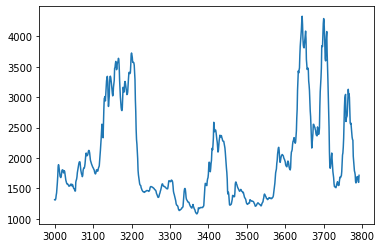

In [19]:
plt.plot(bci['BCI'])

In [35]:
bci=bci.iloc[3000:,]
bci.head()

,date,BCI
3000,2011-Feb-25,1315
3001,2011-Feb-28,1310
3002,2011-Mar-01,1314
3003,2011-Mar-02,1337
3004,2011-Mar-03,1390


In [37]:
scaler = MinMaxScaler()
dt = bci.iloc[:,1:2]
dt = scaler.fit_transform(dt)

train_size = int(len(dt)*0.67)
test_size = int(len(dt)-train_size)

train = dt[0:train_size]
test = dt[train_size:]

# ARIMA 모델

In [38]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 35.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [40]:
import pmdarima as pm
model = pm.auto_arima(train,error_action = 'ignore',trace=1,suppress_warnings = True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3021.413, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2722.828, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3011.580, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2957.453, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2724.826, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3024.430, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3020.562, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3022.960, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3024.384, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3023.983, Time=0.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3022.688, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3020.984, Time=1.36 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3026.295, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3022.590, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0

In [41]:
n_periods = len(test)
pred,confint = model.predict(n_periods = n_periods, return_conf_int=True)

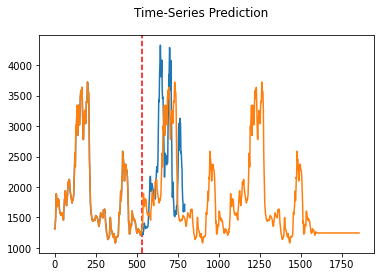

In [44]:
#예측을 진짜 겁나 진짜 못 함
pred = pd.concat([pd.DataFrame(train),pd.DataFrame(pred)])
real = pd.concat([pd.DataFrame(train),pd.DataFrame(test)])
data_predict = pred.values
data_predict = scaler.inverse_transform(data_predict)
real = scaler.inverse_transform(real.values)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(real)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

#lstm

In [47]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [45]:
#window를 설정해주는 함수 여기선 seq_length만큼 이전 data를 이용
def sliding_windows(data,seq_length):
  x = []
  y = []
  for i in range(len(data)-seq_length-1):
    _x = data[i:(i+seq_length)]
    _y = data[i+seq_length]
    x.append(_x)
    y.append(_y)

  return np.array(x),np.array(y)

In [48]:
class LSTM(nn.Module):

    def __init__(self, output, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.output = output
        self.num_layers = num_layers#lstm의 층 개수
        self.input_size = input_size#sliding된 window size를 넣음
        self.hidden_size = hidden_size#hidden dimensiong을 얼마나 가져 갈 것 인가
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [49]:
seq_length = 90#해운운임지수가 3개월 별로 변하기에 90으로 설정
x, y = sliding_windows(dt, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [50]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1
output = 1

lstm = LSTM(output, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.90160
Epoch: 100, loss: 0.02253
Epoch: 200, loss: 0.00199
Epoch: 300, loss: 0.00153
Epoch: 400, loss: 0.00130
Epoch: 500, loss: 0.00107
Epoch: 600, loss: 0.00085
Epoch: 700, loss: 0.00068
Epoch: 800, loss: 0.00058
Epoch: 900, loss: 0.00052
Epoch: 1000, loss: 0.00049
Epoch: 1100, loss: 0.00045
Epoch: 1200, loss: 0.00043
Epoch: 1300, loss: 0.00040
Epoch: 1400, loss: 0.00038
Epoch: 1500, loss: 0.00036
Epoch: 1600, loss: 0.00034
Epoch: 1700, loss: 0.00033
Epoch: 1800, loss: 0.00031
Epoch: 1900, loss: 0.00030


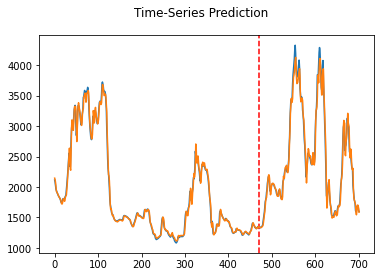

In [52]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()